In [1]:
import torch
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import torch.nn as nn

In [8]:
cs_labels=['black','green','red','cyan','magenta',
           'blue','orange','yellow','goldenrod']
load_dict=torch.load("8obj_divangs_15.pth")
pc=load_dict["dense_pt"]
cs=torch.tensor(load_dict["pt_class"]).int()

In [136]:
load_dict.keys()

dict_keys(['poses', 'dense_pt', 'pt_class', 'colors', 'pt_loc', 'eef_poses', 'T', 'eef_idx', 'J', 'trans_L', 'rot_L'])

In [9]:
def position_encoding_vectorized(x, L=10,freq_w=0.75):
    device = x.device
    n, _ = x.shape
    frequencies = 2 ** (freq_w*torch.linspace(0, L - 1, L, device=device))  # 2^0, 2^1, ..., 2^(L-1)
    frequencies = frequencies.view(1, L, 1)
    x = x.unsqueeze(1)  # Now x has shape (n, 1, 2)
    sin_encodings = torch.sin(x * frequencies)  # Broadcasting happens here
    cos_encodings = torch.cos(x * frequencies)  # Broadcasting happens here
    encoded_x=torch.cat([sin_encodings.view(n, -1),cos_encodings.view(n, -1)],dim=-1)
    return encoded_x

In [10]:
#occupancy classifier
occ_net=nn.Sequential(nn.Linear(60,256),nn.ReLU(),
                      nn.Linear(256,256),nn.ReLU(),
                      nn.Linear(256,1)).cuda()

In [14]:
opt=torch.optim.Adam(occ_net.parameters(),lr=1e-4)
bloss=nn.BCELoss()

In [15]:
batch_size=50000
n_iter=3000

In [16]:
for it in range(n_iter):
    opt.zero_grad()
    inds=torch.randperm(len(pc))[:batch_size]
    xx=pc[inds].cuda()
    
    neg=torch.rand((batch_size,3)).cuda()
    neg=neg*1.2
    neg[:,0]-=0.2
    neg[:,1]-=0.6
    neg[:,2]-=0.2
    
    xx_all=torch.cat([xx,neg])
    yy=torch.zeros((2*batch_size,1)).cuda()
    yy[:batch_size]=1.
    
    pred_c=nn.Sigmoid()(occ_net(position_encoding_vectorized(xx_all)))
    loss=bloss(pred_c,yy)
    if(it%200==0):
        print("{}: {}".format(it,loss))
    loss.backward()
    opt.step()

0: 0.01884540542960167
200: 0.013670013286173344
400: 0.012788244523108006
600: 0.014086447656154633
800: 0.01270364224910736
1000: 0.011857587844133377
1200: 0.012212984263896942
1400: 0.011931242421269417
1600: 0.012972399592399597
1800: 0.010940022766590118
2000: 0.012031582184135914
2200: 0.010830570943653584
2400: 0.011464877985417843
2600: 0.011006509885191917
2800: 0.010933559387922287


In [18]:
# color network
col_net=nn.Sequential(nn.Linear(60,256),nn.ReLU(),
                      nn.Linear(256,256),nn.ReLU(),
                      nn.Linear(256,9)).cuda()
cs_tor=cs.long()
criterion = nn.CrossEntropyLoss()

In [21]:
opt_col=torch.optim.Adam(col_net.parameters(),lr=1e-4)

In [22]:
for it in range(n_iter):
    opt_col.zero_grad()
    inds=torch.randperm(len(pc))[:batch_size]
    xx=pc[inds].cuda()
    yy=cs_tor[inds].cuda()
    pred_col=col_net(position_encoding_vectorized(xx))
    loss=criterion(pred_col,yy[:,0])
    if(it%200==0):
        print("{}: {}".format(it,loss))
    loss.backward()
    opt_col.step()

0: 0.0562703013420105
200: 0.05424566939473152
400: 0.055610541254282
600: 0.05494322627782822
800: 0.055131345987319946
1000: 0.05297202616930008
1200: 0.05533827096223831
1400: 0.05419335141777992
1600: 0.05448870733380318
1800: 0.05355215445160866
2000: 0.05292739346623421
2200: 0.05254119262099266
2400: 0.05341269448399544
2600: 0.05409673973917961
2800: 0.051861148327589035


In [118]:
pred_col.argmax(dim=1)

tensor([2, 0, 2,  ..., 5, 0, 0], device='cuda:0')

In [94]:
def unproject_points(points_2d, K, R, t):
    # Inverse of camera intrinsic matrix
    K_inv = torch.inverse(K)

    # Convert 2D points to homogeneous coordinates
    points_2d_homogeneous = torch.cat((points_2d, torch.ones(points_2d.shape[0], 1, device=points_2d.device)), dim=1)

    # Apply inverse of camera intrinsics to get points in camera coordinates
    points_cam_homogeneous = torch.mm(points_2d_homogeneous, K_inv.t())

    # Normalize points to ensure they lie on the camera's image plane
    points_cam = points_cam_homogeneous / points_cam_homogeneous[:, -1:]

    # The origin of rays in camera coordinates is the camera origin, which can be taken as [0, 0, 0]
    ray_origins = torch.zeros(points_cam.shape[0], 3, device=points_cam.device)

    # The direction of rays is the points in camera coordinates minus the camera origin
    ray_directions = points_cam[:, :3] - ray_origins

    # Transform ray directions from camera coordinates to world coordinates using the inverse of R and -R.T * t for translation
    R_inv = torch.inverse(R)
    ray_directions_world = torch.mm(ray_directions, R_inv.t())

    # The ray origins in world coordinates are obtained by applying the inverse transformation to the camera origin (which is -R.T * t)
    ray_origins_world = -torch.mm(t.unsqueeze(0), R_inv.t())

    return ray_origins_world, ray_directions_world

In [108]:
poses_selected=torch.linalg.inv(load_dict["poses"][0])
print(poses_selected)

tensor([[ 0.5623, -0.8177,  0.1334, -0.1980],
        [-0.5432, -0.4862, -0.6858,  0.1337],
        [ 0.6246,  0.3128, -0.7176,  0.3153],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])


In [162]:
focal_length = 590.
px = 320 # Principal point x-coordinate
py = 240 # Principal point y-coordinate
K = torch.tensor([[focal_length, 0., px],
[0, focal_length, py],
[0, 0, 1]])
# Define the camera transformation matrix T (R and t)
R = poses_selected[:3,:3]
t = poses_selected[:3,3]


In [163]:
# Image dimensions
height = 480
width = 640

x_coords = torch.linspace(0, width - 1, width)
y_coords = torch.linspace(0, height - 1, height)
grid_x, grid_y = torch.meshgrid(x_coords, y_coords, indexing="xy")
points_2d = torch.stack([grid_x.flatten(), grid_y.flatten()], dim=1)
ray_origins_world, ray_directions_world = unproject_points(points_2d, K, R, t)

In [167]:
# Depth linspace from 0.05 to 1.5 (30 points)
depths = torch.linspace(0.05, 1., 100)

In [168]:
projected_points = ray_origins_world + ray_directions_world.unsqueeze(1)*depths[None,:,None]
#projected_points = projected_points.reshape(height, width, depths.size(0), 3)
projected_points=projected_points.cuda()

In [169]:
projected_points

tensor([[[ 0.0142, -0.1474,  0.3178],
         [ 0.0194, -0.1383,  0.3129],
         [ 0.0246, -0.1291,  0.3080],
         ...,
         [ 0.5167,  0.7382, -0.1559],
         [ 0.5219,  0.7473, -0.1608],
         [ 0.5271,  0.7565, -0.1657]],

        [[ 0.0143, -0.1475,  0.3178],
         [ 0.0194, -0.1384,  0.3129],
         [ 0.0246, -0.1292,  0.3081],
         ...,
         [ 0.5176,  0.7369, -0.1557],
         [ 0.5228,  0.7460, -0.1606],
         [ 0.5280,  0.7551, -0.1654]],

        [[ 0.0143, -0.1475,  0.3178],
         [ 0.0195, -0.1384,  0.3130],
         [ 0.0247, -0.1293,  0.3081],
         ...,
         [ 0.5186,  0.7355, -0.1555],
         [ 0.5238,  0.7446, -0.1603],
         [ 0.5290,  0.7537, -0.1652]],

        ...,

        [[ 0.0225, -0.2111,  0.2972],
         [ 0.0292, -0.2142,  0.2884],
         [ 0.0360, -0.2173,  0.2796],
         ...,
         [ 0.6787, -0.5112, -0.5596],
         [ 0.6854, -0.5143, -0.5684],
         [ 0.6922, -0.5174, -0.5772]],

        [[

In [170]:
#for each ray query and get first occuppied position
class_list_pix=[]
for ii in range(0,len(projected_points),1):
    ray_occupancy=nn.Sigmoid()(occ_net(position_encoding_vectorized(projected_points[ii])))
    threshold = 0.6
    condition = ray_occupancy > threshold
    # Get the first index where the condition is true
    index = torch.where(condition)[0][0] if condition.any() else None
    if(index==None):
        class_assigned = torch.zeros(1,1) # other class
    else:
        collision_pos=projected_points[ii][index].reshape((-1,3))
        pred_col=col_net(position_encoding_vectorized(collision_pos))
        class_assigned=pred_col.argmax(dim=1).reshape((-1,1))
    class_list_pix.append(class_assigned.detach().cpu())

In [171]:
class_list_pix_tor=torch.cat(class_list_pix)

In [172]:
class_list_pix_img=class_list_pix_tor.reshape(height, width)

In [158]:
class_list_pix_img.shape

torch.Size([480, 640])

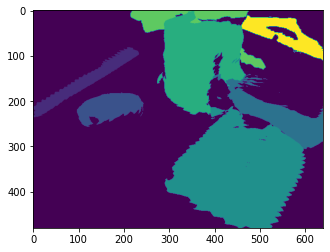

In [159]:
plt.imshow(class_list_pix_img)

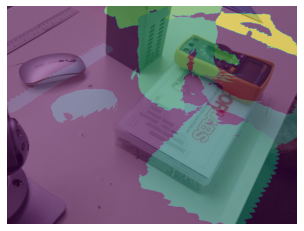

In [161]:
import matplotlib.image as mpimg

# Load the image
img = mpimg.imread('8obj_divangs_a.jpg')

# Display the image
plt.imshow(img)
plt.imshow(class_list_pix_img,alpha=0.5)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()